In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [2]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
import astropy.units as u
import os
import sys
import stella
from tqdm import tqdm_notebook

/Users/mschochet/anaconda3/envs/stellarflares/lib/python3.13/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [3]:
#20s cadence
tess_lc20 = lk.read('/Users/mschochet/Desktop/MSU_PHD/20s/tess2025206162959-s0095-0000000441420236-0292-a_fast-lc.fits')

#120s cadence
tess_lc120 = lk.read('/Users/mschochet/Desktop/MSU_PHD/120s/tess2025206162959-s0095-0000000441420236-0292-s_lc.fits')

In [4]:
ds = stella.DownloadSets()#fn_dir='/Users/mschochet/.stella/models/',)
ds.download_models()
OUT_DIR = '/Users/mschochet/Desktop/stella_results/'


Models have already been downloaded to ~/.stella/models


In [5]:
cnn = stella.ConvNN(output_dir=OUT_DIR)

Can only use stella.ConvNN.predict().


In [6]:
cnn.predict(modelname=str(ds.models[0]),
            times=tess_lc120.time.value,
            fluxes=tess_lc120.flux,
            errs=tess_lc120.flux_err)
single_pred = cnn.predictions[0]

  0%|          | 0/1 [00:00<?, ?it/s]

473/473 [==============================] - 1s 1ms/step


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


In [7]:
preds = np.zeros((len(ds.models),len(cnn.predictions[0])))

for i, m in enumerate(ds.models):
    cnn.predict(modelname=m,
                times=tess_lc120.time.value,
                fluxes=tess_lc120.flux,
                errs=tess_lc120.flux_err)
    preds[i] = cnn.predictions[0]

avg_pred = np.nanmedian(preds, axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

473/473 [==============================] - 1s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

473/473 [==============================] - 1s 970us/step


  0%|          | 0/1 [00:00<?, ?it/s]

473/473 [==============================] - 1s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

473/473 [==============================] - 1s 956us/step


  0%|          | 0/1 [00:00<?, ?it/s]

473/473 [==============================] - 1s 999us/step


  0%|          | 0/1 [00:00<?, ?it/s]

473/473 [==============================] - 0s 927us/step


  0%|          | 0/1 [00:00<?, ?it/s]

473/473 [==============================] - 0s 876us/step


  0%|          | 0/1 [00:00<?, ?it/s]

473/473 [==============================] - 1s 979us/step


  0%|          | 0/1 [00:00<?, ?it/s]

473/473 [==============================] - 1s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

473/473 [==============================] - 1s 1ms/step


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


In [8]:
stella_lc = lk.LightCurve(flux=cnn.predict_flux[0], time = cnn.predict_time[0], flux_err = cnn.predict_err[0])
stella_lc.to_csv('stella/stella_lc.csv', overwrite=True) 
with open('stella/stella_probabilities.npy', 'wb') as f:
    np.save(f, avg_pred)

In [9]:
with open('stella/stella_probabilities.npy', 'rb') as f:
    avg_pred = np.load(f)
stella_lc.add_column(avg_pred, name='probs')

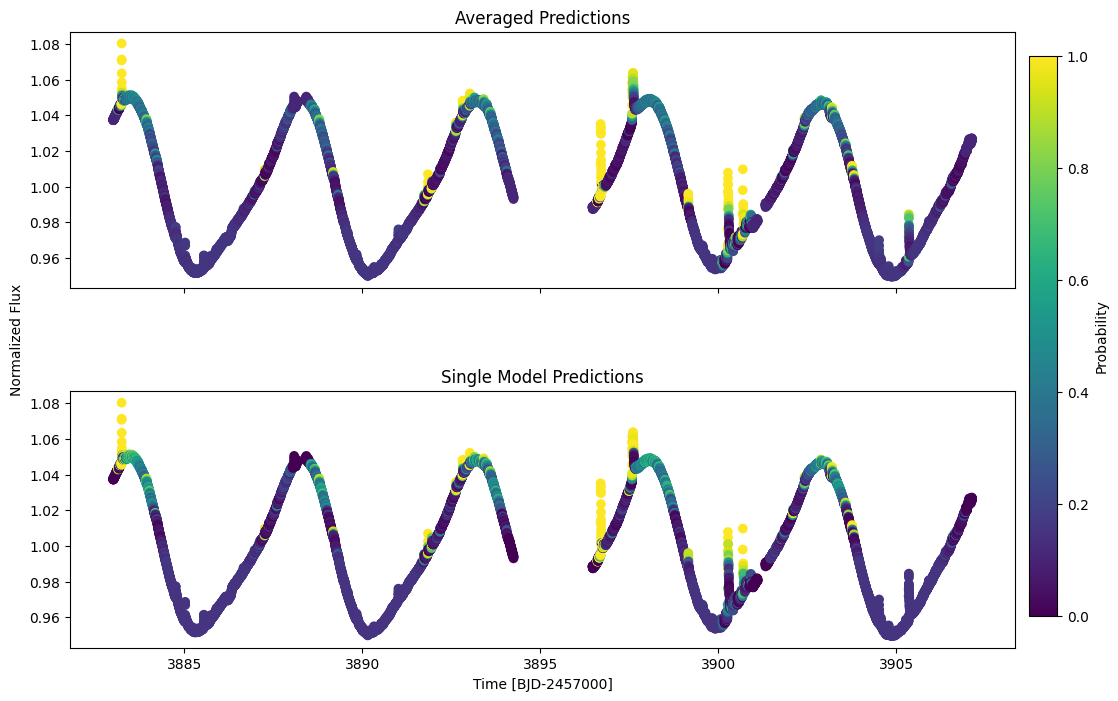

In [10]:
fig, (ax1, ax2) = plt.subplots(figsize=(14,8), nrows=2,
                               sharex=True, sharey=True)
im = ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1)
ax2.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=single_pred, vmin=0, vmax=1)
ax2.set_xlabel('Time [BJD-2457000]')
ax2.set_ylabel('Normalized Flux', y=1.2)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Probability')

ax1.set_title('Averaged Predictions')
ax2.set_title('Single Model Predictions')

plt.subplots_adjust(hspace=0.4);